In [18]:
import re
import random
import pandas as pd
import hashlib

In [19]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [20]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
SharePoint,127.073105,7.474889,17
MS Identity Platform,249.075389,62.268847,4
Azure AI Search,315.446515,22.531894,14
Lost in a Good Book,515.335786,25.766789,20
Network Mapping,530.364846,25.255469,21
Taxes,863.737998,86.373800,10
Finance Junk,1022.962066,127.870258,8
Search Engine Optimization,1124.163696,66.127276,17
PP365,1309.302874,130.930287,10
Open Source/GitHub,1310.190956,56.964824,23


# Histogram

40945.27


<Axes: >

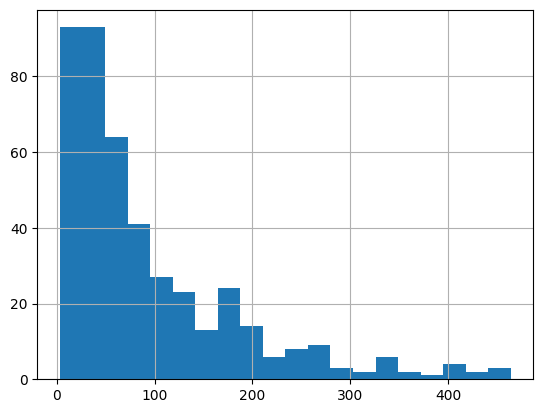

In [21]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [24]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 438


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
124,MS Identity Platform,Confidential client applications: Apps in this...,1bb0c3789de950ab09fa8359d79b8a55,-112.213704,62.268847,-112.213704,249.075389,0.272162,4,112.213704
274,MS Identity Platform,The parties in an authentication flow use bear...,0104d2a194fbb32b4288eca1293504c9,-76.021965,62.268847,-112.213704,249.075389,0.272162,4,112.213704
415,MS Identity Platform,OAuth versus OpenID Connect: The platform uses...,69f4a149f2ed2a85967e6eec1dbe5f2b,-31.117342,62.268847,-112.213704,249.075389,0.272162,4,112.213704
125,MS Identity Platform,If your desktop or mobile application runs on ...,550e4bb1c653449e9d2e441e94990462,-29.722379,62.268847,-112.213704,249.075389,0.272162,4,112.213704
3,Python,"In computer programming jargon, a heisenbug is...",36b63391c51de64bda2e097303f5a91c,-464.275897,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
160,Python,Because the decoding of bytes to a str require...,bd27f134b74a2829a40f6c953483f1ed,-294.728332,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
308,Python,The print() function allows you to control the...,2fa67dd81ca813c197797f3dfe69aafc,-191.643014,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
4,Python,"In Python, special methods support comparison ...",fda018b0b93b0865cf1ada114d19a584,-175.055382,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
161,Python,"On UNIX-like systems, readline is part of Pyth...",f886c154eb8e437abefc15ad037e9a0c,-113.707110,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
309,Python,"If you invoke Response.raise_for_status(), the...",7b9415f877c5fcc40a358ae8ded54d73,-98.168952,177.911465,-464.275897,1423.291717,0.933801,8,464.275897


# Focus on one header

In [25]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [26]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [27]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [29]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [30]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [31]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [33]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
124,MS Identity Platform,Confidential client applications: Apps in this...,1bb0c3789de950ab09fa8359d79b8a55,-112.213704,62.268847,-112.213704,249.075389,0.272162,4,112.213704
274,MS Identity Platform,The parties in an authentication flow use bear...,0104d2a194fbb32b4288eca1293504c9,-76.021965,62.268847,-112.213704,249.075389,0.272162,4,112.213704
415,MS Identity Platform,OAuth versus OpenID Connect: The platform uses...,69f4a149f2ed2a85967e6eec1dbe5f2b,-31.117342,62.268847,-112.213704,249.075389,0.272162,4,112.213704
125,MS Identity Platform,If your desktop or mobile application runs on ...,550e4bb1c653449e9d2e441e94990462,-29.722379,62.268847,-112.213704,249.075389,0.272162,4,112.213704
3,Python,"In computer programming jargon, a heisenbug is...",36b63391c51de64bda2e097303f5a91c,-464.275897,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
160,Python,Because the decoding of bytes to a str require...,bd27f134b74a2829a40f6c953483f1ed,-294.728332,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
308,Python,The print() function allows you to control the...,2fa67dd81ca813c197797f3dfe69aafc,-191.643014,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
4,Python,"In Python, special methods support comparison ...",fda018b0b93b0865cf1ada114d19a584,-175.055382,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
161,Python,"On UNIX-like systems, readline is part of Pyth...",f886c154eb8e437abefc15ad037e9a0c,-113.707110,177.911465,-464.275897,1423.291717,0.933801,8,464.275897
309,Python,"If you invoke Response.raise_for_status(), the...",7b9415f877c5fcc40a358ae8ded54d73,-98.168952,177.911465,-464.275897,1423.291717,0.933801,8,464.275897


In [34]:
existing_cards.head(10)['age'].sum()

np.float64(-1586.654077159215)